In [195]:
import MDAnalysis as mda
from MDAnalysis.auxiliary import EDR
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.align as align
import MDAnalysis.analysis.diffusionmap as diffusionmap

#Widgets
import ipywidgets as widgets
from ipywidgets import Box

from modules import *

#Math
import numpy as np

# Import viewer
import nglview

import matplotlib.pyplot as plt

#other general things
import warnings
import os

%reload_ext autoreload
%autoreload 2



## Inputs

### Inputs files and options
run the 2 below cells first to select option, and then run the rest

In [196]:
align_traj = widgets.Checkbox(value=True, description='Align Trajectory',disabled=False,indent=False)
radius_of_gyration = widgets.Checkbox(value=True,description='Calculate Radius of Gyration',disabled=False,indent=False)
calculate_RMSD = widgets.Checkbox(value=False, description='Calculate RMSD',disabled=False,indent=False)
calculate_RMSF = widgets.Checkbox(value=False,description='Calculate RMSF',disabled=False,indent=False)
pairwise_RMSD =  widgets.Checkbox(value=False,description='Calculate Pairwise RMSD',disabled=False,indent=False)
optionbox = Box(children=[align_traj,radius_of_gyration,calculate_RMSD,calculate_RMSF,pairwise_RMSD])
optionbox


Box(children=(Checkbox(value=True, description='Align Trajectory', indent=False), Checkbox(value=True, descrip…

In [197]:
edr_only =  widgets.Checkbox(value=False,description='only run EDR analysys',disabled=False,indent=False)
EDRbox = Box(children=[edr_only])
EDRbox

Box(children=(Checkbox(value=False, description='only run EDR analysys', indent=False),))

In [198]:
### Needed input
sim_path = "S:\\Work\\gromacs\\Cs2RBM-2\\"
ligand_name = None #set to None if no ligand
coordinate_file_name = 'md250ns_po_start.pdb'             ##tpr or gro file tpr needed for h bond
trajectory_file_name = 'md250ns_center_po.xtc'      ##xtc file
auxiliary_file_name = 'md250ns.edr'              ##edr file
reference_structure_path = 'md1ns.gro'

sim_name = 'default' ##output pdb file will use thise name, if set to "default" will use the auxilliary file name

#Options
#RMSD_groups = ["284 to 400" , "400 to 426" ]
#RMSD_groups_name = ["Core" , "C-term" ]
RMSD_groups = ["1 to 92"]
RMSD_groups_name = ["all"]
H_bonds = False
start_frame = 100
stop_frame = None



if sim_name == 'default':
    sim_name = auxiliary_file_name.split(".")[0]

RMSD_groups_name.insert(0, "Overall")

if edr_only.value:
    align_traj = None
    radius_of_gyration = None
    calculate_RMSD = None
    calculate_RMSF = None
    pairwise_RMSD =  None


### Reading and preprocessing

In [199]:
## Read the diferents files
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    if not edr_only.value:
        reference_structure = mda.Universe(sim_path + reference_structure_path,)
        if os.path.isfile(sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc"): ## read the aligned file if it exist
            atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
            print("Aligned file found, reading this instead")
            is_aligned = True
        else:
            atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name)
            is_aligned = False
    energy_like_terms = EDR.EDRReader(sim_path + auxiliary_file_name)


Aligned file found, reading this instead


In [200]:
if align_traj.value:
    if not is_aligned:
        atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name)
        do_trajectory_CAalignement(atomistic_system, sim_path, trajectory_file_name)
        atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
        is_aligned = True
    else:
        print(f"Trajectory allready aligned, delete {trajectory_file_name.split('.')[0] + '_aligned.xtc'} to rerun alignement")

Trajectory allready aligned, delete md250ns_center_po_aligned.xtc to rerun alignement


## Sanity Check
Check that simulation isn't going wrong, read temperature and pressure through the EDR <br>
list of the available data can be obtained with: <br>


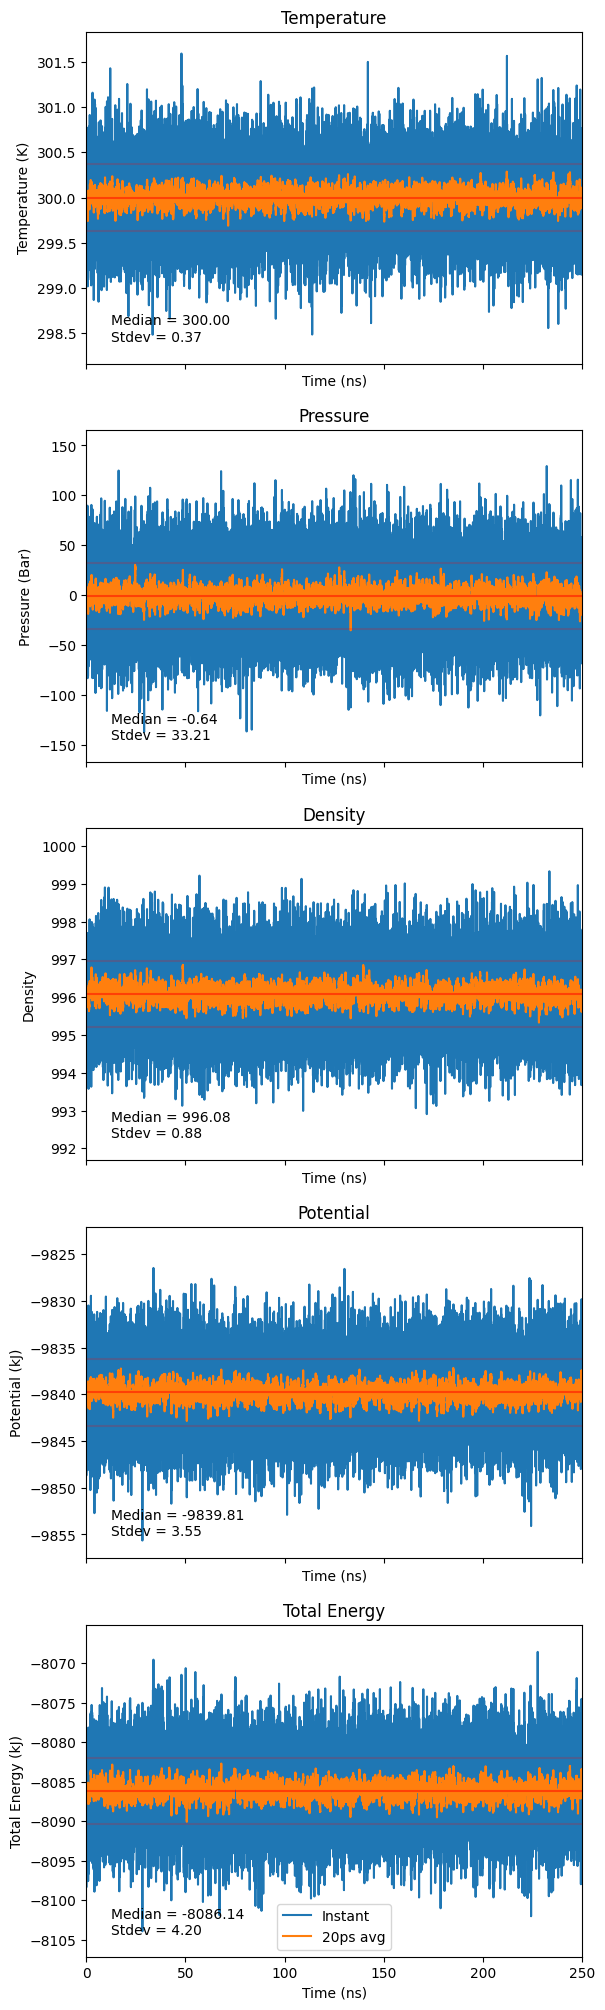

In [201]:
fig, axs = plt.subplots(5, sharex=True)
fig.set(figheight=25)
edr_plot(energy_like_terms, axs[0],'Temperature', "K", edr_only=edr_only.value)
edr_plot(energy_like_terms, axs[1],'Pressure', "Bar", edr_only=edr_only.value)
edr_plot(energy_like_terms, axs[2],'Density', edr_only=edr_only.value)
edr_plot(energy_like_terms, axs[3],'Potential', "kJ", divide = 1000, edr_only=edr_only.value)
edr_plot(energy_like_terms, axs[4],'Total Energy', "kJ", divide = 1000, edr_only=edr_only.value)
plt.legend()


### Box size

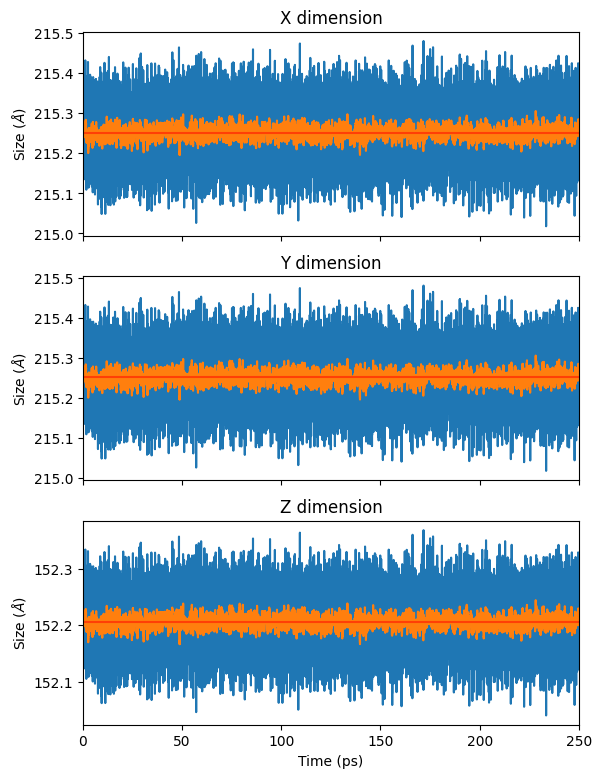

In [202]:
#Get and plot Density data
box_plot(energy_like_terms)


## View the simulation

In [203]:
# Open an NGLView widget
view = nglview.show_mdanalysis(atomistic_system, default_representation=False)
# Add the atomistic system to the widget
view.add_representation('cartoon', selection='protein')

#view.add_representation('licorice', selection='water')

# Add spacefill representtaion for the ions (Potassium, Chloride)
view.add_representation('spacefill', selection='.POT .CLA', opacity=0.5)


# Center the view
if ligand_name:
    try:
        test = atomistic_system.select_atoms(f"resname {ligand_name}")[0] # crash if ligand name corespond to nothing
        view.center(ligand_name)
        view.add_representation('licorice', selection= ligand_name )
    except:
        view.center('protein')
else:
    view.center('protein')

# Set the view to orthographic
view.camera = 'orthographic'

# Show the view in the widget
view

NGLWidget(max_frame=25000)

## Analysis

### Radius of gyration

s:\Work\gromacs\GROMACS-tools\analysis\modules.py:122: SyntaxWarning: invalid escape sequence '\A'
  
s:\Work\gromacs\GROMACS-tools\analysis\modules.py:150: SyntaxWarning: invalid escape sequence '\A'
  
s:\Work\gromacs\GROMACS-tools\analysis\modules.py:279: SyntaxWarning: invalid escape sequence '\A'
  factor = 10
s:\Work\gromacs\GROMACS-tools\analysis\modules.py:380: SyntaxWarning: invalid escape sequence '\A'
  # Show plot
s:\Work\gromacs\GROMACS-tools\analysis\modules.py:546: SyntaxWarning: invalid escape sequence '\A'
  fig.set(figheight=14)


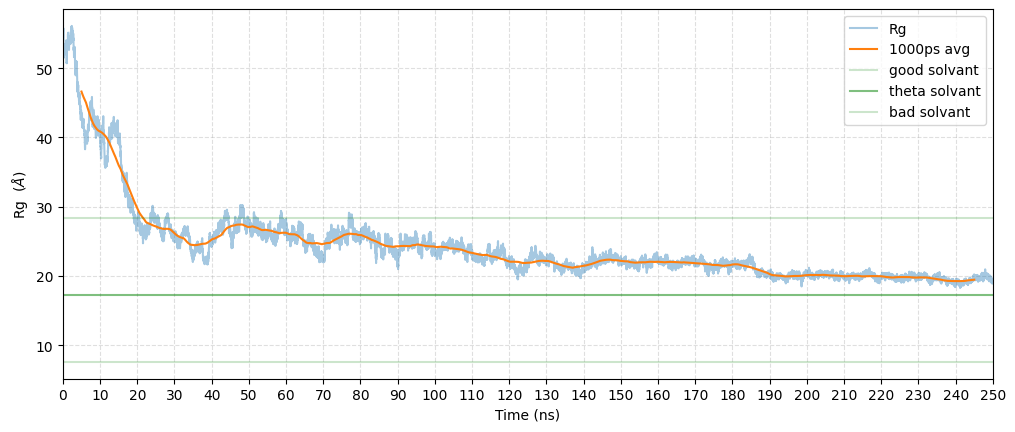

In [224]:
#@title <b><font color='#45B69C'>3.1 - Run MD simulation</font></b>
#@markdown Simulation time (ns):
Simulation_time = "AUTO" #@param {type:"raw"}

if radius_of_gyration.value:
    Rgyr = Rg(atomistic_system)

17.327434893832383  28.38152685653678  7.61316324655447


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


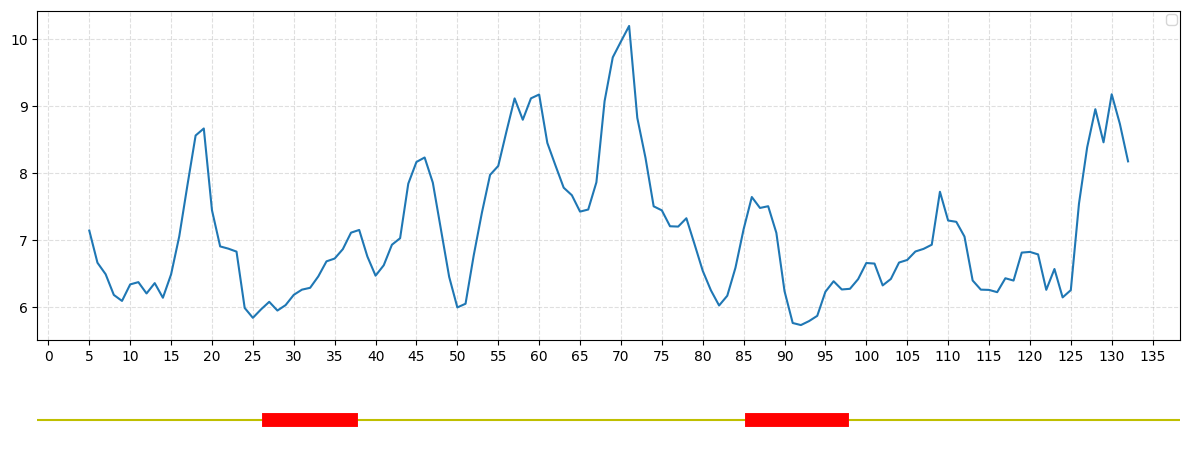

In [205]:
typical_step_lengh = 3.6 # Angstrom
n_resids =  len(atomistic_system.residues.resids)
theta_Rg =  typical_step_lengh * math.sqrt(n_resids/6)
expanded_Rg = (typical_step_lengh * n_resids**(3/5) ) / math.sqrt(6)
collapsed_Rg = (typical_step_lengh * n_resids**(1/3) )/ math.sqrt(6)

print(f"{theta_Rg}  {expanded_Rg}  {collapsed_Rg}")


start = 24900
stop = 25000

residues_window = 10
theta_Rg =  typical_step_lengh * math.sqrt(residues_window/6)
expanded_Rg = (typical_step_lengh * residues_window**(3/5) ) / math.sqrt(6)
collapsed_Rg = (typical_step_lengh * residues_window**(1/3) )/ math.sqrt(6)
rolling_Rgs = np.zeros((stop - start, len(atomistic_system.residues.resids) - residues_window - 1))

for k, ts in enumerate(range(start, stop)):
    atomistic_system.trajectory[ts]

    for i in range(1, len(atomistic_system.residues.resids) - residues_window):
        start = i
        finish = i + residues_window
        sele =  atomistic_system.select_atoms(f"resid {start} to {finish}")
        rolling_Rgs[k][i-1]= sele.radius_of_gyration()
    

center_resids = np.arange(residues_window/2, len(atomistic_system.residues.resids) - residues_window/2 -1, 1)
rolling_Rgs_avg = np.mean(rolling_Rgs, axis = 0)

fig = plt.figure()
fig.set(figwidth=12)
#import matplotlib.gridspec as gridspec
spec = fig.add_gridspec(2,1,height_ratios=[4,1])
ax = fig.add_subplot(spec[0,0])

ax.xaxis.set_ticks(np.arange(0,n_resids , 5))
ax.grid(visible = True, linestyle = '--', alpha=0.4)
ax.plot(center_resids, rolling_Rgs_avg)
'''
ax.axhline(y = expanded_Rg, color = 'g', linestyle = '-', alpha = 0.2, label="good solvant")
ax.axhline(y = theta_Rg, color = 'g', linestyle = '-', alpha = 0.5, label="theta solvant")
ax.axhline(y = collapsed_Rg, color = 'g', linestyle = '-', alpha = 0.2, label="bad solvant")
'''

ss = fig.add_subplot(spec[1,0], sharex=ax)
ss.axhline(y = 4, color = 'y', linestyle = '-')
ss.axis("off")
ss.grid(visible = True, linestyle = '--', alpha=0.4)
ss.plot((27,37),(4,4), color = 'r', linewidth=10)
ss.plot((86,97),(4,4), color = 'r', linewidth=10)

fig.tight_layout()
fig.legend(loc='upper right', borderaxespad=1)


In [206]:
if radius_of_gyration.value:
    distances_3Darray = calculate_3D_distance(atomistic_system)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


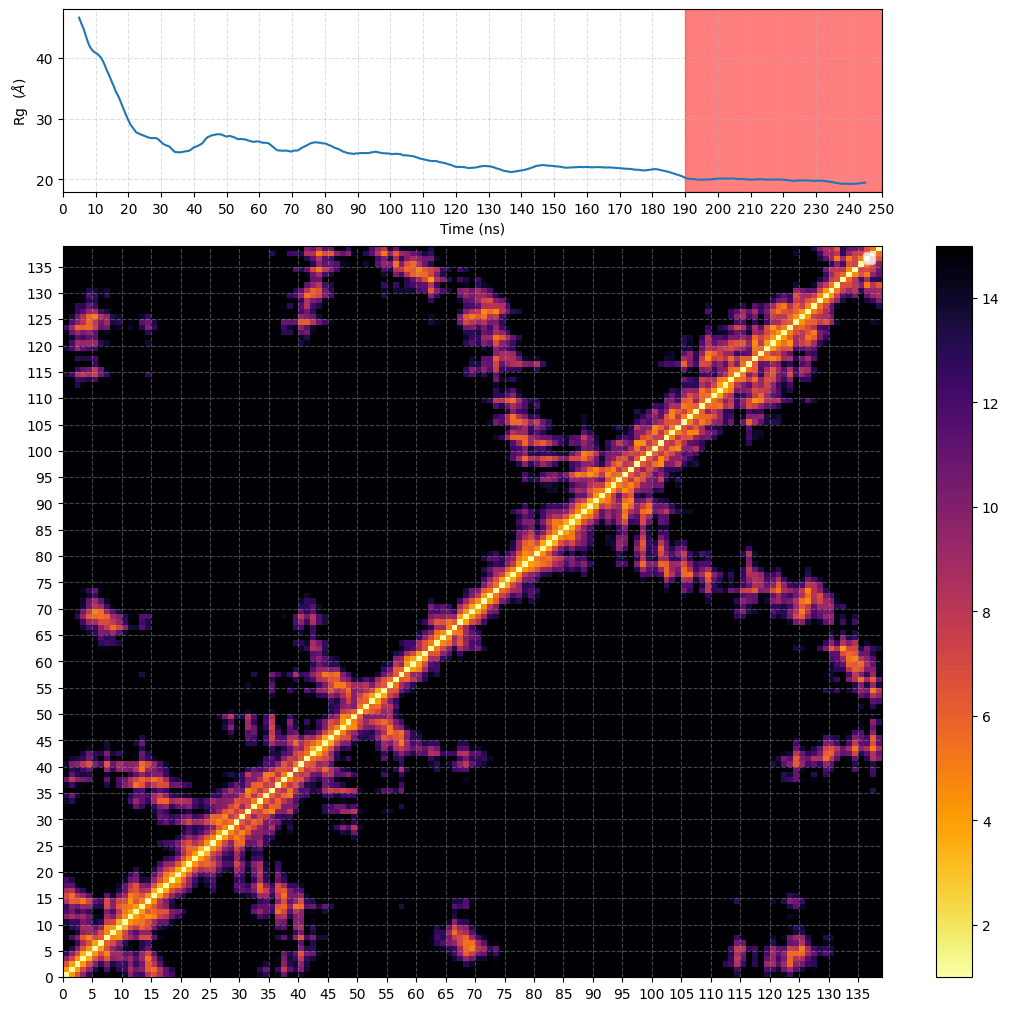

In [207]:
dist_max = 15
contact_start = 190
contact_finish = 250

if radius_of_gyration.value:
    plot_distances_HD(Rgyr, distances_3Darray, contact_start, contact_finish, dist_max)
    
    ## Extras
    #plot_distances_slices(distances_3Darray, contact_start, contact_finish, dist_max)
    #mean = np.mean(distances_3Darray[contact_start *100 : contact_finish *100], axis=0)
    #np.savetxt(f"{sim_path}distances_avg_{contact_start}ns-{contact_finish}ns.csv", mean, delimiter="," )
    cutoff = 12
    #plot_every_diagonal(distances_3Darray, contact_start,contact_finish, cutoff) ## it's pretty terrible don't look at it

In [208]:
residues = []
for i, residue in enumerate(atomistic_system.residues.resnames):
    residues.append(f"{atomistic_system.residues.resnames[i]}{atomistic_system.residues.resids[i]}")
print(residues)


['SER1', 'THR2', 'PRO3', 'ALA4', 'PRO5', 'ALA6', 'SER7', 'TYR8', 'SER9', 'ALA10', 'PRO11', 'ALA12', 'ALA13', 'SER14', 'TYR15', 'THR16', 'ALA17', 'PRO18', 'ALA19', 'ALA20', 'ALA21', 'PRO22', 'ALA23', 'GLY24', 'GLY25', 'LEU26', 'SER27', 'ALA28', 'GLU29', 'GLN30', 'ARG31', 'GLU32', 'PHE33', 'LEU34', 'GLU35', 'ARG36', 'LYS37', 'ALA38', 'ARG39', 'GLU40', 'SER41', 'ARG42', 'SER43', 'PRO44', 'ALA45', 'PRO46', 'VAL47', 'GLU48', 'THR49', 'ARG50', 'GLY51', 'ARG52', 'SER53', 'ALA54', 'PRO55', 'ARG56', 'PRO57', 'ARG58', 'SER59', 'ALA60', 'SER61', 'PRO62', 'ARG63', 'PRO64', 'THR65', 'SER66', 'ARG67', 'THR68', 'PRO69', 'ALA70', 'PRO71', 'ALA72', 'SER73', 'TYR74', 'SER75', 'ALA76', 'PRO77', 'ALA78', 'ALA79', 'SER80', 'TYR81', 'SER82', 'ALA83', 'PRO84', 'ALA85', 'ALA86', 'ALA87', 'PRO88', 'ALA89', 'GLY90', 'GLY91', 'LEU92', 'SER93', 'ALA94', 'GLU95', 'GLN96', 'ARG97', 'GLU98', 'PHE99', 'MET100', 'GLU101', 'ARG102', 'LYS103', 'ALA104', 'ARG105', 'GLU106', 'SER107', 'ARG108', 'SER109', 'PHE110', 'SER111

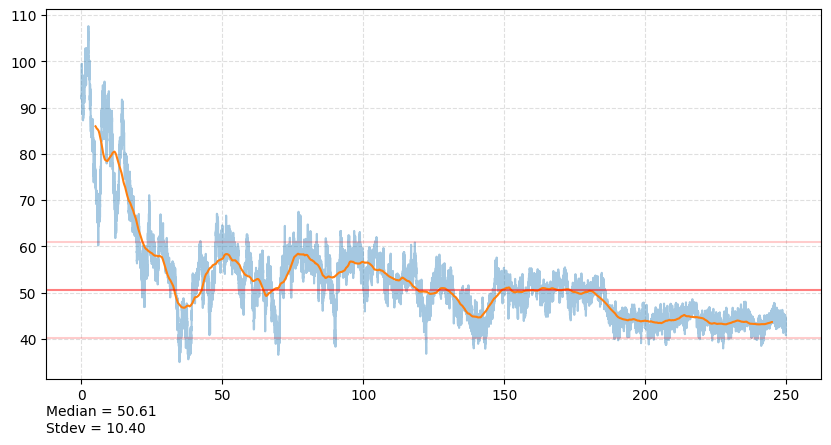

In [225]:
seleA = "resid 36"
seleB = "resid 100"
sele_distance(atomistic_system, seleA, seleB)

### Salt Bridges formation

In [210]:
salt_bridge_cutoff =4.5
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = atomistic_system.select_atoms(sel_acidic)
basic = atomistic_system.select_atoms(sel_basic)

charges_distances_3Darray, byresidues_cd_3Darray, total_contacts = salt_bridges_detection(atomistic_system,acidic, basic, salt_bridge_cutoff)


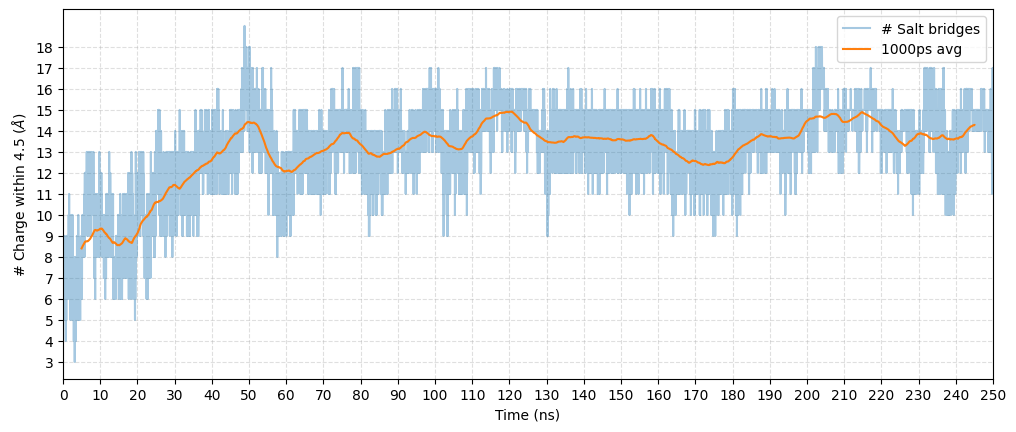

In [211]:
salt_bridges_plot(total_contacts, salt_bridge_cutoff)

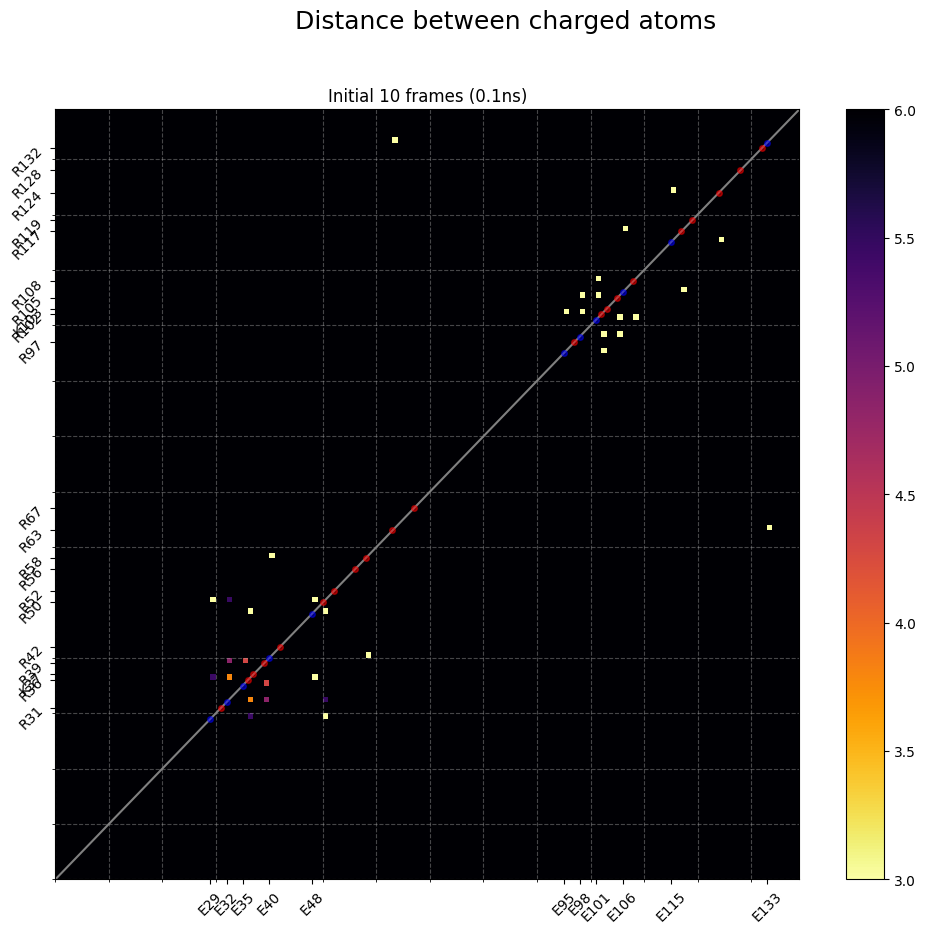

In [212]:
contact_start = 135
contact_finish = 250
dist_max = 6
#salt_brdige_overtime(acidic, basic,  charges_distances_3Darray, atomistic_system,contact_start, contact_finish, dist_max)
salt_brdige_singlepoint(acidic, basic, charges_distances_3Darray, atomistic_system, contact_start, dist_max)

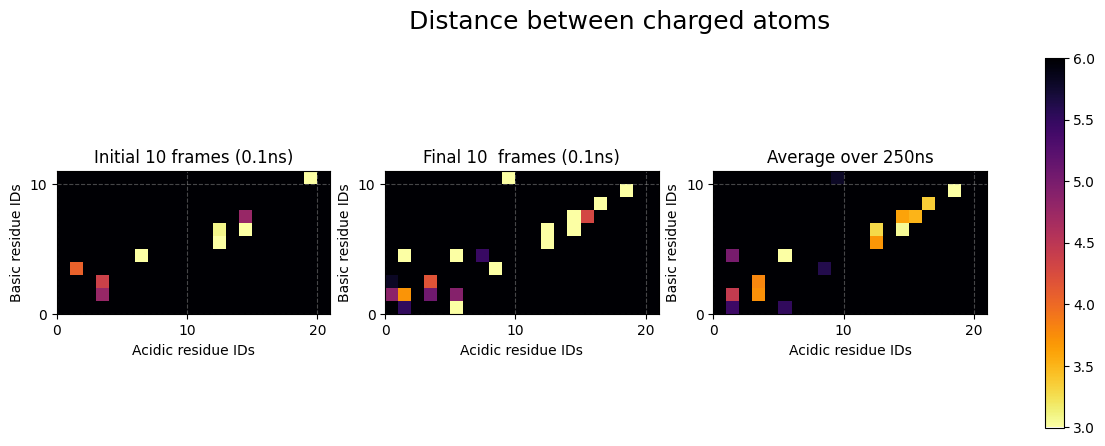

In [213]:
contact_start = 0
contact_finish = 250
dist_max = 6

import matplotlib as mpl

fig, axes = plt.subplots(1,3)
fig.set(figwidth=15)
fig.suptitle('Distance between charged atoms', fontsize=18)

initial_10frames = np.mean(byresidues_cd_3Darray[contact_start *100 : contact_start *100 + 10], axis=0)
final_10frames = np.mean(byresidues_cd_3Darray[contact_finish *100 -10 :contact_finish *100], axis=0)

im0 = axes[0].pcolormesh(initial_10frames,vmin=3, vmax=dist_max, cmap = plt.cm.inferno_r)
im1 = axes[1].pcolormesh(final_10frames,vmin=3, vmax=dist_max, cmap = plt.cm.inferno_r)

charges_distances_average = np.mean(byresidues_cd_3Darray[contact_start *100 : contact_finish *100], axis=0)                                                 
im2 = axes[2].pcolormesh(charges_distances_average,vmin=3, vmax=dist_max, cmap = plt.cm.inferno_r)
# plt.pcolor gives a rectangular grid by default
# so we need to make our heatmap square
for ax in axes:
    ax.set_aspect('equal')
    ax.set_ylabel('Basic residue IDs')
    ax.set_xlabel('Acidic residue IDs')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 10))
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 10))
    ax.grid(visible = True, linestyle = '--', alpha=0.4)
    
axes[0].set_title('Initial 10 frames (0.1ns)')
axes[1].set_title('Final 10  frames (0.1ns)')
axes[2].set_title(f'Average over {contact_finish - contact_start}ns')

# colorbar
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im2, cax=cax, **kw)

### RMSD
Measure RMS deviation from the original structure during the simulation time


In [214]:
if calculate_RMSD.value:
    grouplist =[]
    for group in RMSD_groups:
        grouplist.append(f"protein and name CA and resid {group}")

    # Calculate RMSD using the MDAnalysis functionality
    ref_structure = reference_structure

    # Input: simulation trajectory, reference structure, atoms to superimpose, atoms to calculate the RMSD for
    RMSD = rms.RMSD(atomistic_system,      # Trajectory
                    ref_structure,         # Reference structure
                    select="protein and name CA",   #residus selection for superimposition     
                    groupselections = grouplist)  # RMSD groups
    # Run RMSD analysis
    RMSD.run(verbose=True)

In [215]:
if calculate_RMSD.value:
    #Option to start the plot at specific time (cut of first ms of equilibration)
    plot_0 = 0
    # Extract data for plotting
    rmsd = RMSD.results.rmsd.T  #T = transpose
    # Extract the time data from the RMSD output. Divide by 1000 to get time in ns
    time = rmsd[1]/1000
    
    plot_RMSD(rmsd, time, RMSD_groups, RMSD_groups_name, plot_0)

### Pairwise RMSD

In [216]:
if pairwise_RMSD.value:
    aligner = align.AlignTraj(atomistic_system, atomistic_system, select='name CA',in_memory=False,filename="tmp.xtc")
    aligner.run(verbose=True)

    aligned_atomistic_system = mda.Universe(sim_path + coordinate_file_name,"tmp.xtc")
    matrix = diffusionmap.DistanceMatrix(aligned_atomistic_system, select='name CA')
    matrix.run(verbose=True)
    print(matrix.results.dist_matrix.shape)

In [217]:
if pairwise_RMSD.value:
    plt.imshow(matrix.dist_matrix, cmap='viridis')
    plt.xlabel('Frame')
    plt.ylabel('Frame')
    plt.colorbar(label=r'RMSD ($\AA$)')



### RMSF
Calculate RMS fluctuation per residues from an <b>average structure</b>.

In [218]:
# Generate an average structure
if calculate_RMSF.value:
    
    if not is_aligned:
        do_trajectory_CAalignement(atomistic_system, sim_path, trajectory_file_name)
        atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
        is_aligned = True
     
#Run RMSF analysis
    C_alphas = atomistic_system.select_atoms('protein and name CA')
    print("Run RMSF calculation")
    RMSF = rms.RMSF(C_alphas)
    RMSF.run(verbose=True)

In [219]:
if calculate_RMSF.value:
    # Plot the data - RMSF against residue index
    fig, ax = plt.subplots()

    ax.plot(C_alphas.resids, RMSF.results.rmsf, label='RMSF')
    # Add axis labels
    ax.set_xlabel('Residue number')
    ax.set_ylabel('RMSF  ($\AA$)')

    # Set axis limits
    ax.set_xlim(C_alphas.resids[0], C_alphas.resids[-1] )
    ax.set_ylim(min(RMSF.results.rmsf))

    # plt median and + 1 stdev
    plt_median(ax, RMSF.results.rmsf, negative=False, label=True)


    # Show legend
    plt.legend()
    # Show plot
    plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\A'
<>:8: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Clement\AppData\Local\Temp\ipykernel_10120\2314561365.py:8: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel('RMSF  ($\AA$)')


In [220]:
if calculate_RMSF.value:
    # dynamically add new attributes
    # ('tempfactors' is pre-defined and filled with zeros as default values)
    atomistic_system.add_TopologyAttr('tempfactors')
    C_alphas.tempfactors = RMSF.results.rmsf


#write PDB file with RMS as B factore
    if ligand_name:
        write_group = atomistic_system.select_atoms(f"(protein and name CA) or resname {ligand_name}")
    else:
        write_group = C_alphas

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        write_group.write(sim_path + sim_name +  "_RMSF.pdb")


## H-Bonds

In [221]:
hbonds = False
if H_bonds and ligand_name:
    from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
    hbonds = HBA(universe=atomistic_system, between=["protein", f"resname {ligand_name}"])

# Guess H and accepetors
    protein_H = hbonds.guess_hydrogens("protein")
    protein_acc = hbonds.guess_acceptors("protein")
    ligand_H = hbonds.guess_hydrogens(f"resname  {ligand_name}")
    ligand_acc =  hbonds.guess_acceptors(f"resname {ligand_name}")

    hbonds.hydrogens_sel = f"({protein_H}) or ({ligand_H})"
    hbonds.acceptors_sel = f"({protein_acc}) or ({ligand_acc})"

    hbonds.run(verbose=True, start=start_frame, stop=stop_frame)

In [222]:
if hbonds:
    print(hbonds.results.hbonds.shape)

    plt.plot(hbonds.times, hbonds.count_by_time(), lw=2)

    plt.title("Number of hydrogon bonds over time", weight="bold")
    plt.xlabel("Time (ps)")
    plt.ylabel(r"$N_{HB}$")

    plt.show()

In [223]:
if hbonds:
    for donor, acceptor, count in hbonds.count_by_type():

        donor_resname, donor_type = donor.split(":")
        n_donors = atomistic_system.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms

        # average number of hbonds per donor molecule per frame
        mean_count = 2 * int(count) / (hbonds.n_frames * n_donors)  # multiply by two as each hydrogen bond involves two water molecules
        print(f"{donor} to {acceptor}: {mean_count:.2f}")